In [35]:
#Calculating rolling beta
window = 252
hedge_ratio = []

for i in range(window, len(data)):
    y = data[stock1].iloc[i-window:i]
    x = sm.add_constant(data[stock2].iloc[i-window:i])
    model = sm.OLS(y, x).fit()
    hedge_ratio.append(model.params[stock2])
    
hedge_ratio = pd.Series(hedge_ratio, index = data.index[window:])

#Calculating rolling spread 
spread = data[stock1].iloc[window:] - hedge_ratio.values * data[stock2].iloc[window:]

#Calculating rolling mean and std
spread_mean = spread.rolling(window).mean().shift(1)
spread_std = spread.rolling(window).std().shift(1)
zscore = (spread - spread_mean) / spread_std

In [36]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(spread.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -3.664804876671298
p-value: 0.004636340190417448


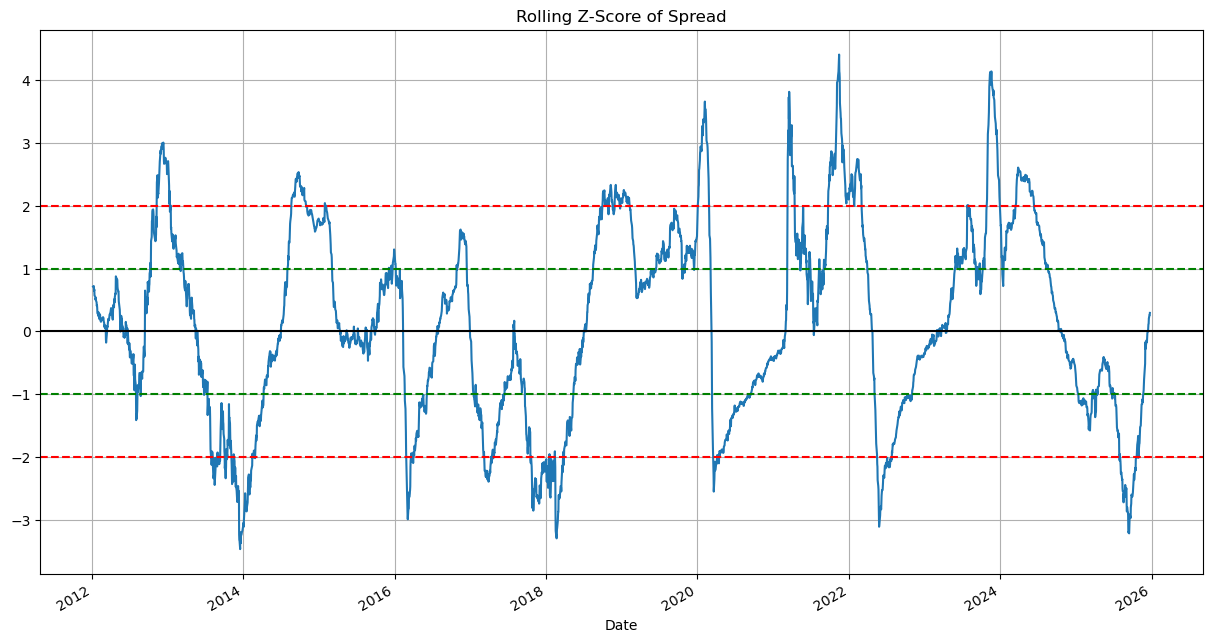

In [37]:
#Plot z-score
zscore.plot(figsize = (15, 8), title = "Rolling Z-Score of Spread")
plt.axhline(0, color = "black", label = "0")
plt.axhline(1, color = "green", linestyle = "--", label = "+1")
plt.axhline(-1, color = "green", linestyle = "--", label = "-1")
plt.axhline(2, color = "red", linestyle = "--", label = "+2")
plt.axhline(-2, color = "red", linestyle = "--", label = "-2")
plt.grid(True)
plt.show()

In [38]:
#Signals
signals = pd.DataFrame(index = zscore.index)
signals["zscore"] = zscore
signals["long_spread"] = zscore < -1.5
signals["short_spread"] = zscore > 1.5
signals["exit"] = (zscore > -0.25) & (zscore < 0.25)

position = []
current_position = 0

for i in range(len(signals)):
    if signals["long_spread"].iloc[i]:
        current_position = 1
    elif signals["short_spread"].iloc[i]:
        current_position = -1
    elif signals["exit"].iloc[i]:
        current_position = 0
        
    position.append(current_position)
    
signals["position"] = position